In [21]:
import pandahouse as ph

In [3]:
'''
Задача 1.
Необходимо выяснить какие пары товаров покупают вместе чаще всего.
1) В таблице t1 отбираю заказы с только купленными товарами. И разбиваю массив ID продуктов заказа на отдельные элементы 
спомощю фунцкии unnest().
2) В таблице t2 заменяю ID заказов на их наименование. И оставляю только уникальные товары в заказах, т.к. один и тот же 
товар могли купить два и более раза.
3) Делаю SELF JOIN таблицы t2 при условии что заказ одинаков и для исключения повторяющихся пар, таких как (фильтр, вата) 
--> (вата, фильтр) и пар с одинаковын наименованием создаю условие "t2.name < t3.name". После группирую полученные пары в 
массив и для каздой пары считаю их повторяющееся количество в заказах.
'''

'\nЗадача 1.\nНеобходимо выяснить какие пары товаров покупают вместе чаще всего.\n1) В таблице t1 отбираю заказы с только купленными товарами. И разбиваю массив ID продуктов заказа на отдельные элементы \nспомощю фунцкии unnest().\n2) В таблице t2 заменяю ID заказов на их наименование. И оставляю только уникальные товары в заказах, т.к. один и тот же \nтовар могли купить два и более раза.\n3) Делаю SELF JOIN таблицы t2 при условии что заказ одинаков и для исключения повторяющихся пар, таких как (фильтр, вата) \n--> (вата, фильтр) и пар с одинаковын наименованием создаю условие "t2.name < t3.name". После группирую полученные пары в \nмассив и для каздой пары считаю их повторяющееся количество в заказах.\n'

In [23]:
query_1 = '''
WITH t1 as (SELECT order_id,
                   unnest(product_ids) as product_id
            FROM   orders
            WHERE  order_id not in (SELECT order_id 
                                    FROM user_actions 
                                    WHERE  action = 'cancel_order')), 
     t2 as (SELECT DISTINCT t1.order_id,
                   p1.name
            FROM t1 
            JOIN products as p1 using(product_id))

SELECT array[t2.name, t3.name] as pair,
       count(array[t2.name, t3.name]) as count_pair
FROM   t2 
JOIN t2 as t3
        ON t2.order_id = t3.order_id and t2.name < t3.name
GROUP BY array[t2.name, t3.name]
ORDER BY count_pair desc, pair
'''

In [ ]:
q_test = ph.read_clickhouse(query=query_1, connection=connection_default)

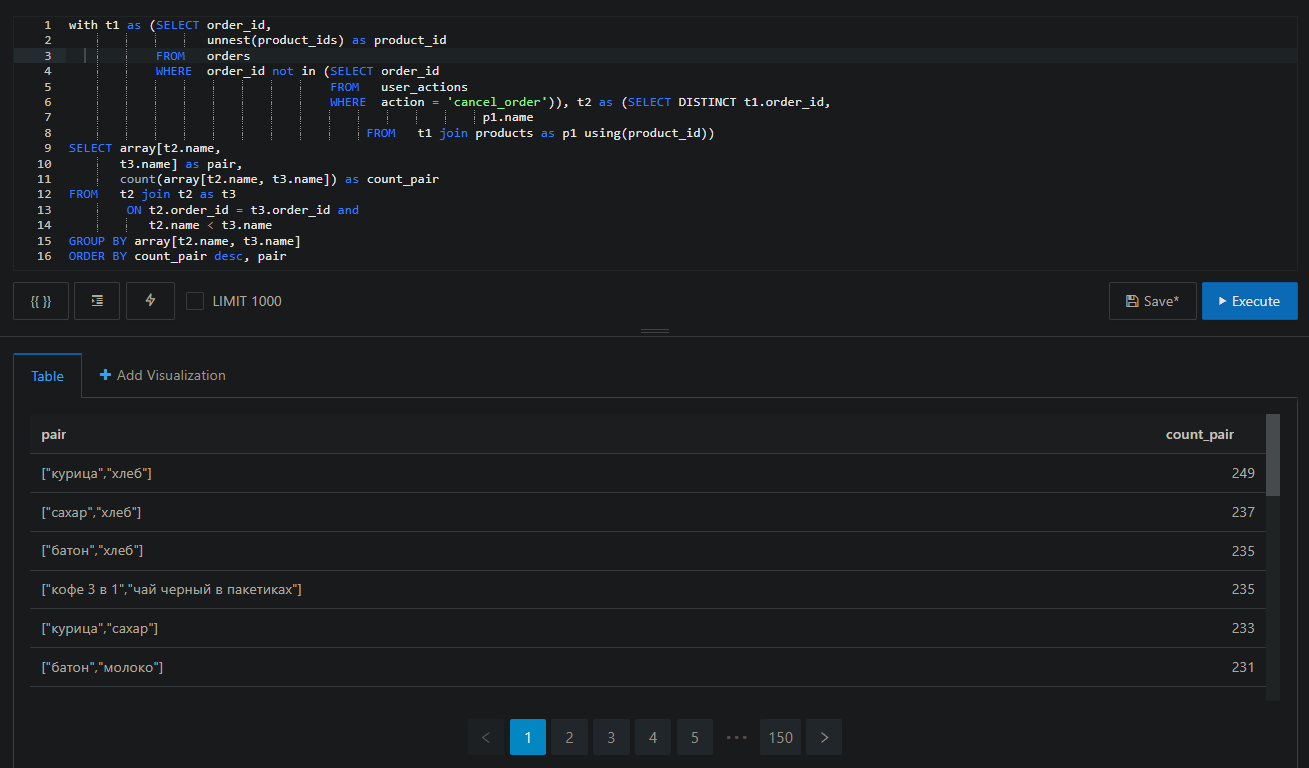

In [4]:
'''
Задача 2.
В блоке WITH: отбираются только те ID заказов, в которых было заказано макситальное количетство продуктов. По итогу их 
вышло 5. В отновном блоке происходит происоединение к таблице user_actions таблиц методом INNER JOIN. Из итогового 
результата отбираются только ID заказов с макситальным колечеством продуктов. Почему DISTINCT спросите вы? Да потомучто 
в таблице courier_actions записаны события создания заказа и дальнейшей его доставки. И чтобы исключить повторение строк 
в итоговом резутьтате применим метод DISTINCT.

"date_part('year', age((SELECT max(time) FROM   user_actions), users.birth_date))::integer" - вычисляется возраст 
пользователя, сделавшего заказ. И аналоличто ниже строчка - вычисляется возраст доставившего курьера. Всё это считается 
относительно максимальной даты в таблице user_actions.

В итоговой таблице отображаются ID заказов с максимальным количеством товаров. Так-же ID пользователей, сделавших этот 
заказ и курьеров, их доставивших. Плюс посчитан возраст каждого.
'''

'\nЗадача 2.\nВ блоке WITH: отбираются только те ID заказов, в которых было заказано макситальное количетство продуктов. По итогу их \nвышло 5. В отновном блоке происходит происоединение к таблице user_actions таблиц методом INNER JOIN. Из итогового \nрезультата отбираются только ID заказов с макситальным колечеством продуктов. Почему DISTINCT спросите вы? Да потомучто \nв таблице courier_actions записаны события создания заказа и дальнейшей его доставки. И чтобы исключить повторение строк \nв итоговом резутьтате применим метод DISTINCT.\n\n"date_part(\'year\', age((SELECT max(time) FROM   user_actions), users.birth_date))::integer" - вычисляется возраст \nпользователя, сделавшего заказ. И аналоличто ниже строчка - вычисляется возраст доставившего курьера. Всё это считается \nотносительно максимальной даты в таблице user_actions.\n\nВ итоговой таблице отображаются ID заказов с максимальным количеством товаров. Так-же ID пользователей, сделавших этот \nзаказ и курьеров, их доставивших. 

In [5]:
query_1 = '''
WITH max_products as (SELECT order_id
                      FROM   orders
                      WHERE  array_length(product_ids, 1) = (SELECT max(array_length(product_ids, 1)) 
                                                             FROM   orders))
SELECT DISTINCT order_id,
       user_id,
       date_part('year', age((SELECT max(time) FROM   user_actions), users.birth_date))::integer as user_age, 
       courier_id, 
       date_part('year', age((SELECT max(time) FROM   user_actions), couriers.birth_date))::integer as courier_age

FROM user_actions 
JOIN users             using(user_id) 
JOIN courier_actions   using(order_id) 
JOIN couriers          using(courier_id) 
WHERE order_id in (SELECT order_id FROM max_products)
'''

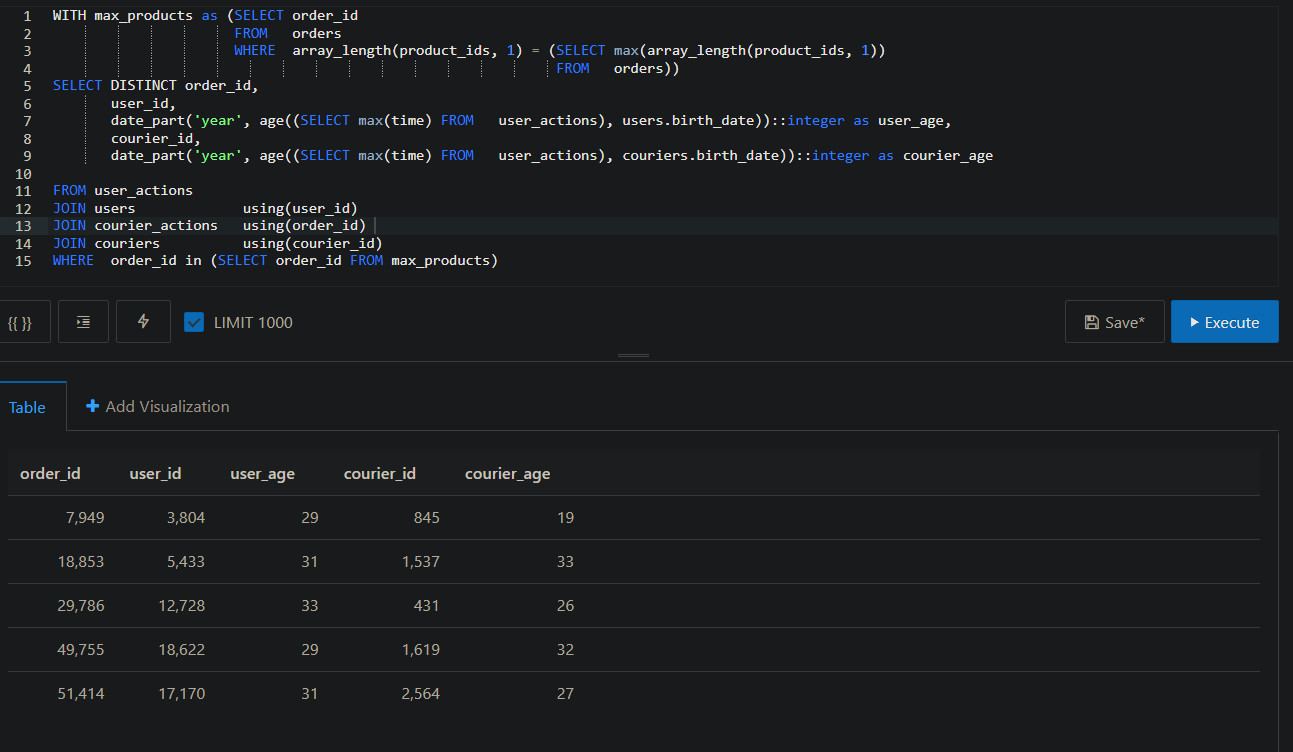

In [ ]:
vv